# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [3]:
import pandas as pd
import numpy as np
# ! pip install lightgbm
import lightgbm as lgb

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [4]:
df_train = pd.read_csv("../../../datasets/competencia2_2022.csv.gz")

Xtrain = df_train[df_train["foto_mes"] == 202101]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

/home/santiago/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (154) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [5]:
Xbajas = df_train.query("foto_mes == 202101 and clase_ternaria != 'CONTINUA'")

Y nos deshacemos del target y limpiamos un poco la memoria.

In [6]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [7]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Y miramos su importancia de variables

In [8]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


Features  Importances
5                  cliente_edad          141
107                ctrx_quarter          126
8          mrentabilidad_annual          119
10              mactivos_margen          103
22               mcuentas_saldo           91
..                          ...          ...
76                   cforex_buy            0
75                       cforex            0
70   mtarjeta_master_descuentos            0
69   ctarjeta_master_descuentos            0
77                   mforex_buy            0

[154 rows x 2 columns]

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [11]:
#! pip install shap
import shap

/home/santiago/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/santiago/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 575 kB 5.2 MB/s eta 0:00:01


In [34]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [35]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
0             -0.004904       0.0             0.0          0.0 -0.002334   
1             -0.013970       0.0             0.0          0.0 -0.004382   
2             -0.022926       0.0             0.0          0.0 -0.001292   
3             -0.018709       0.0             0.0          0.0 -0.002978   
4             -0.012726       0.0             0.0          0.0 -0.002094   
...                 ...       ...             ...          ...       ...   
1509           0.022436       0.0             0.0          0.0 -0.001274   
1510           0.014711       0.0             0.0          0.0 -0.002212   
1511           0.015259       0.0             0.0          0.0 -0.002597   
1512           0.005852       0.0             0.0          0.0 -0.003329   
1513           0.018028       0.0             0.0          0.0 -0.002379   

      cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
0         0.043758            0.013983      -0.041278              0.196130   
1         0.048569            0.011794       0.006623             -0.096754   
2        -0.410950            0.011234       0.023368              0.058636   
3        -0.213675            0.009803      -0.010034             -0.031874   
4        -0.203420            0.014232      -0.044485              0.168928   
...            ...                 ...            ...                   ...   
1509      0.045961           -0.071549       0.013633             -0.094009   
1510      0.031978           -0.073241       0.003024             -0.105791   
1511      0.053010           -0.078954       0.022112             -0.120325   
1512     -0.179921           -0.070015      -0.004753             -0.104875   
1513      0.015552           -0.139793       0.023018             -0.058858   

      mcomisiones  ...  Visa_madelantodolares  Visa_fultimo_cierre  \
0        0.000189  ...                    0.0            -0.000616   
1       -0.011399  ...                    0.0             0.001421   
2        0.006585  ...                    0.0             0.001724   
3       -0.016405  ...                    0.0             0.001045   
4       -0.012609  ...                    0.0            -0.002317   
...           ...  ...                    ...                  ...   
1509    -0.014529  ...                    0.0             0.001330   
1510     0.000905  ...                    0.0             0.001267   
1511    -0.005999  ...                    0.0             0.001442   
1512    -0.015815  ...                    0.0             0.001135   
1513     0.003393  ...                    0.0             0.001300   

      Visa_mpagado  Visa_mpagospesos  Visa_mpagosdolares  Visa_fechaalta  \
0         0.011454         -0.014267           -0.002817       -0.021265   
1        -0.057956         -0.006672            0.011768        0.004617   
2        -0.030290          0.008067           -0.001562       -0.001833   
3        -0.000576         -0.014958           -0.003360       -0.063228   
4         0.011874         -0.029288           -0.002845       -0.056215   
...            ...               ...                 ...             ...   
1509      0.001324         -0.026429           -0.002340        0.062294   
1510      0.000154         -0.013291            0.011133        0.055093   
1511      0.000127         -0.011322            0.013452        0.080696   
1512     -0.000063         -0.009317            0.012196        0.086014   
1513     -0.000924         -0.004851            0.009382        0.034476   

      Visa_mconsumototal  Visa_cconsumos  Visa_cadelantosefectivo  \
0                    0.0       -0.015299                      0.0   
1                    0.0       -0.003721                      0.0   
2                    0.0       -0.007120                      0.0   
3                    0.0       -0.000538                      0.0   
4                    0.0       -0.005447     

Y consolidamos sus importancias

In [36]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter                     0.966983
cpayroll_trx                     0.611897
mtarjeta_visa_consumo            0.195651
mcuentas_saldo                   0.170158
mpasivos_margen                  0.141330
                                   ...   
cseguro_auto                     0.000000
cseguro_accidentes_personales    0.000000
mpayroll2                        0.000000
mcheques_emitidos_rechazados     0.000000
mforex_buy                       0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

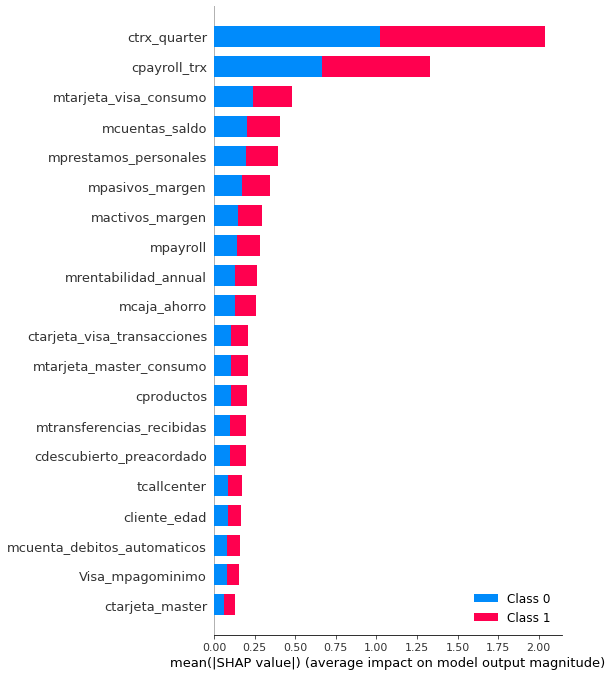

In [37]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

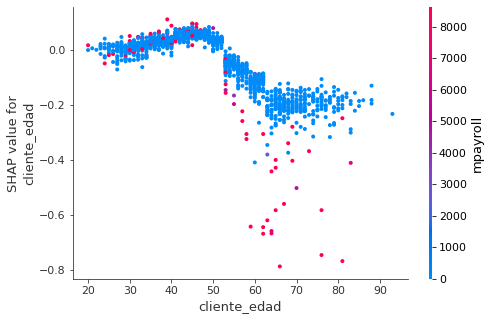

In [38]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [333]:
from umap import UMAP
import matplotlib.pyplot as plt


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


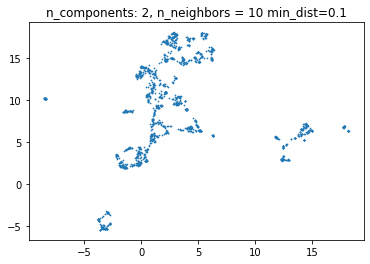

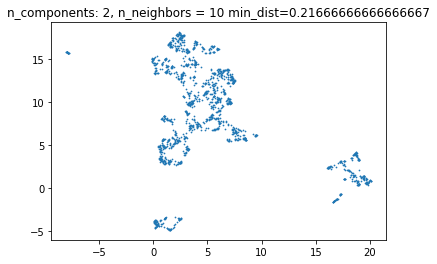

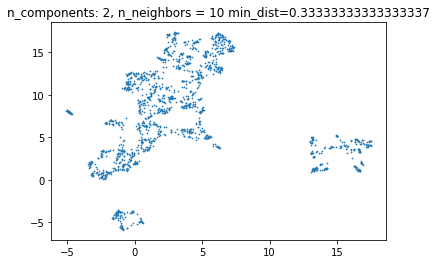

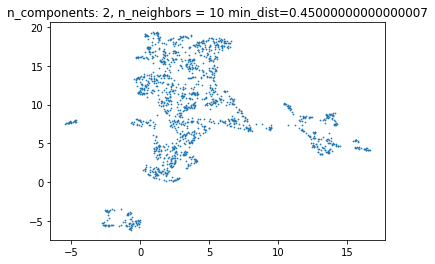

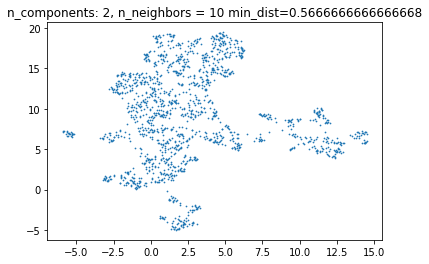

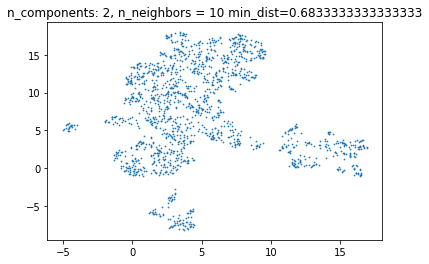

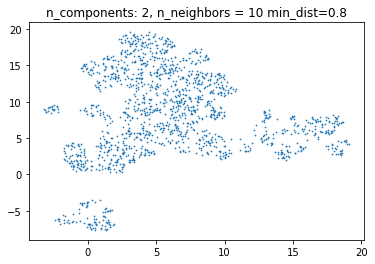

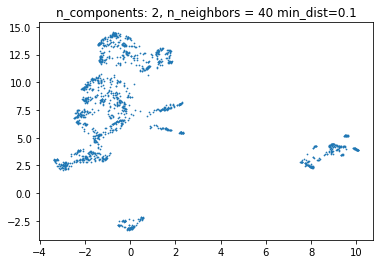

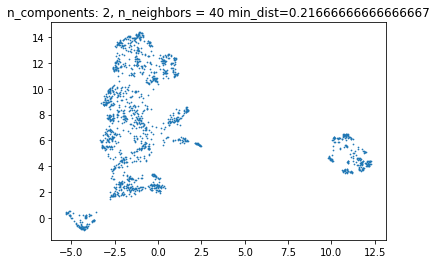

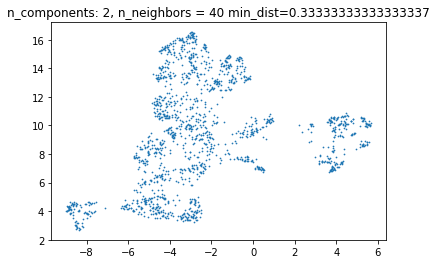

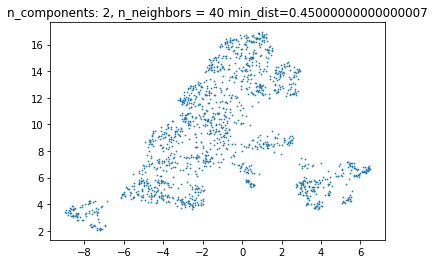

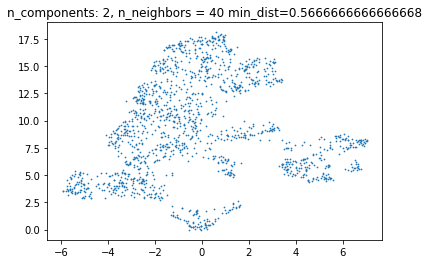

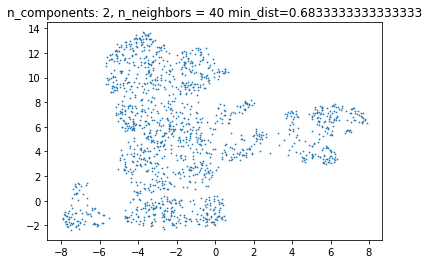

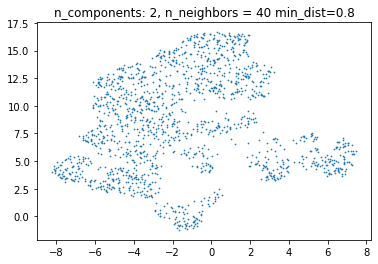

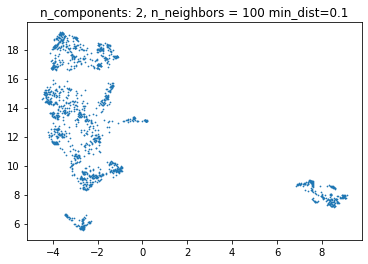

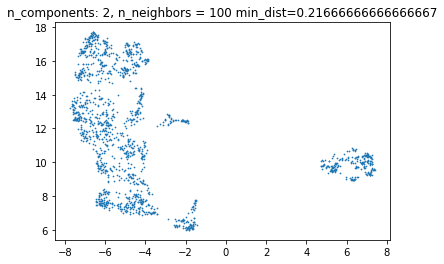

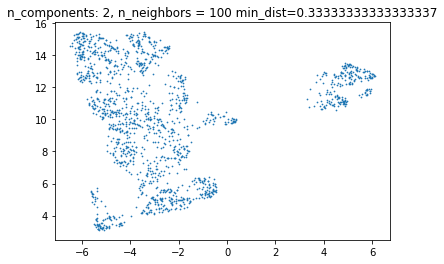

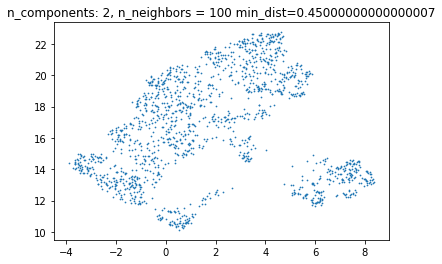

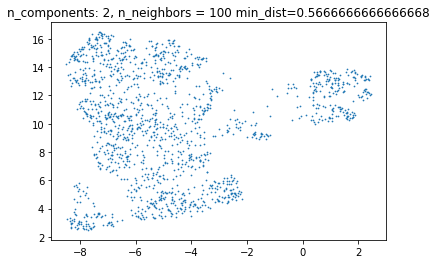

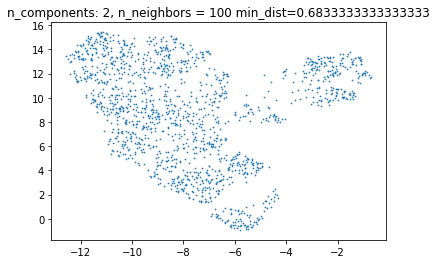

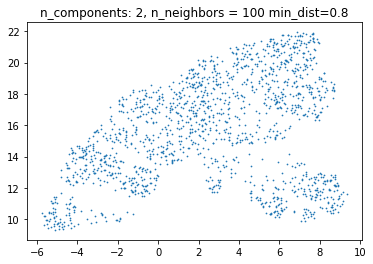

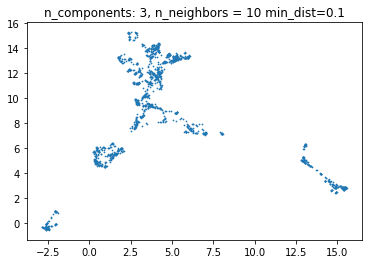

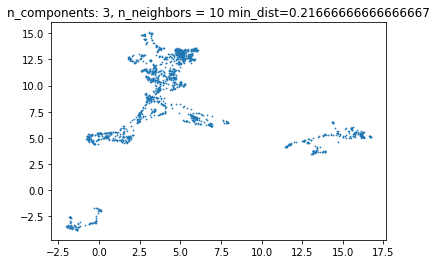

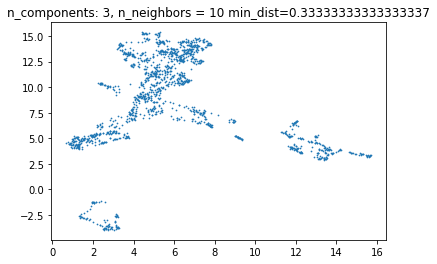

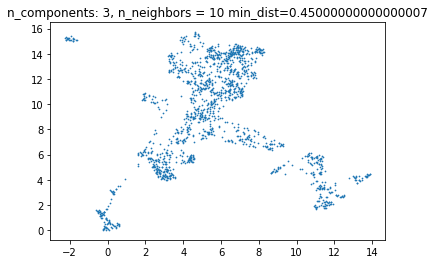

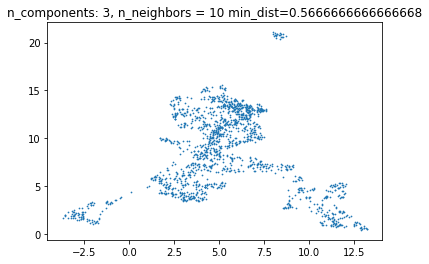

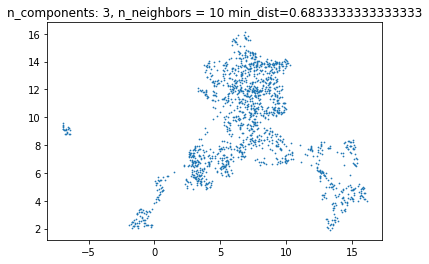

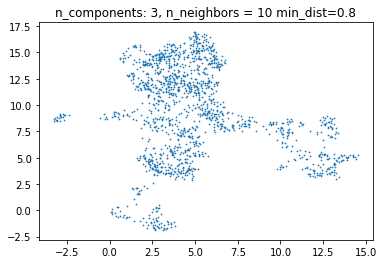

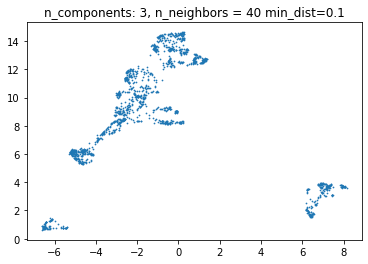

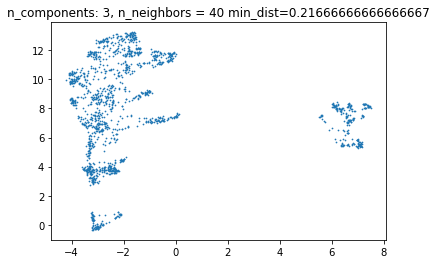

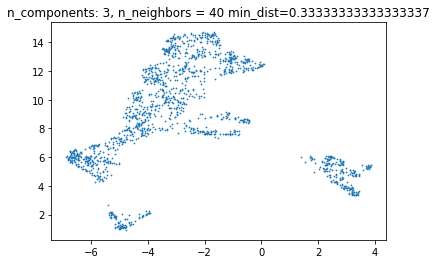

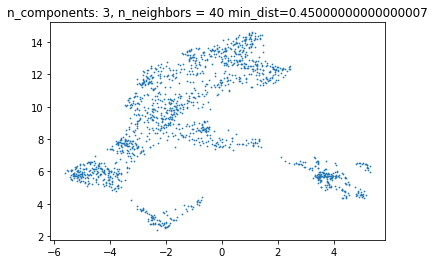

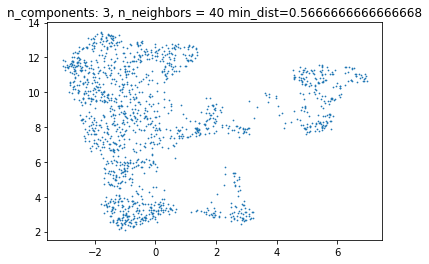

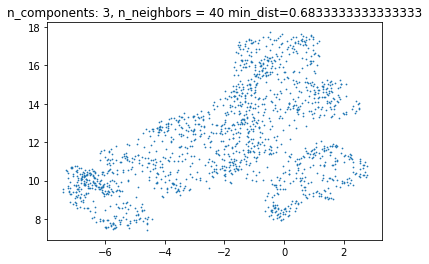

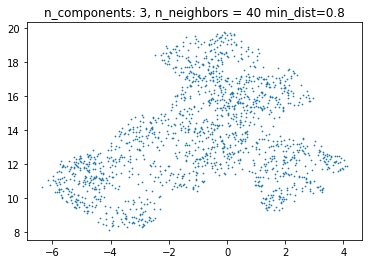

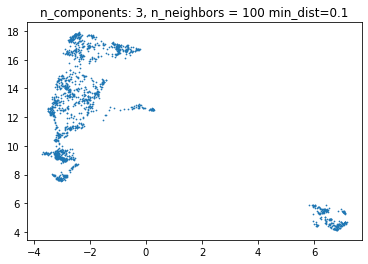

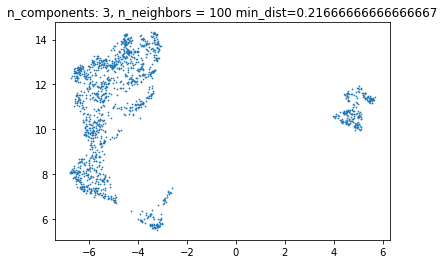

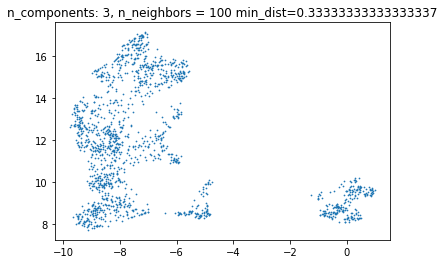

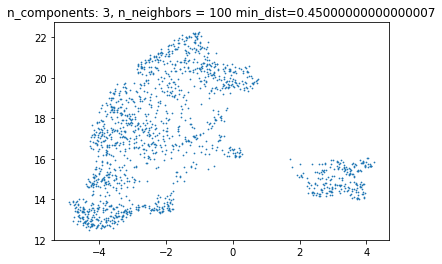

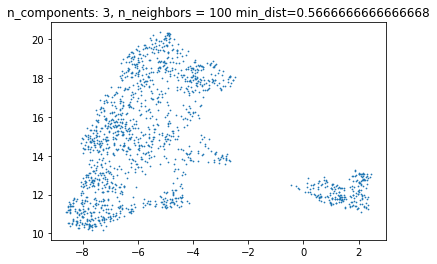

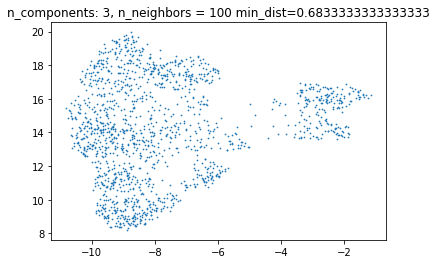

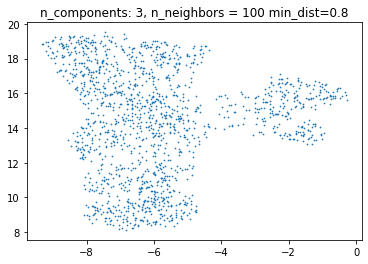

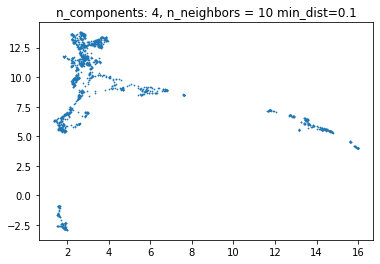

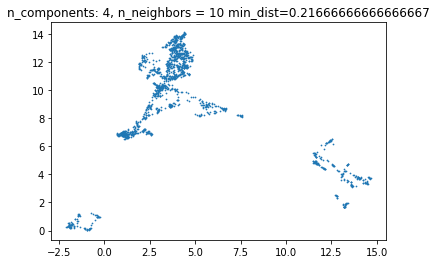

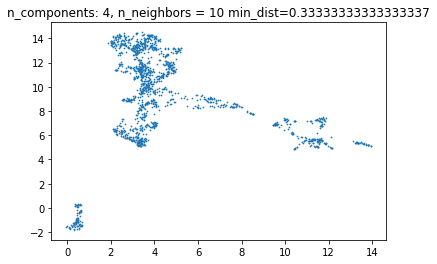

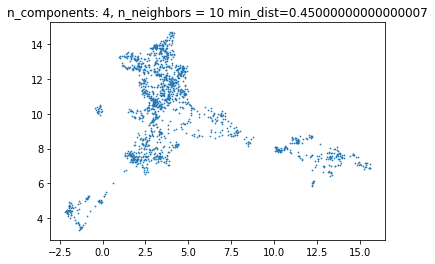

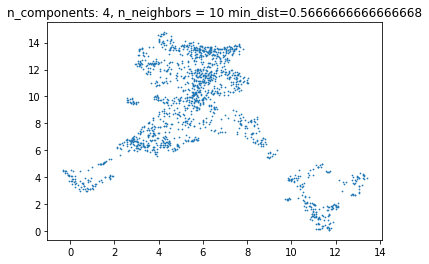

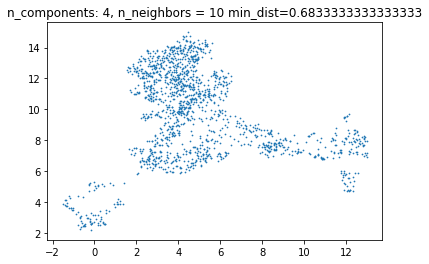

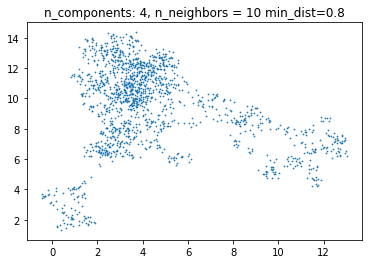

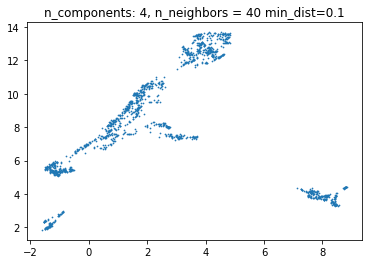

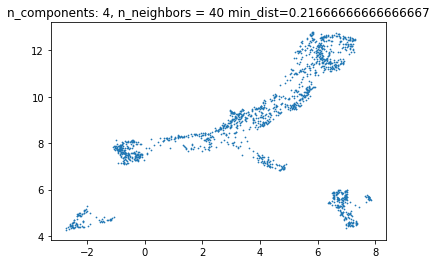

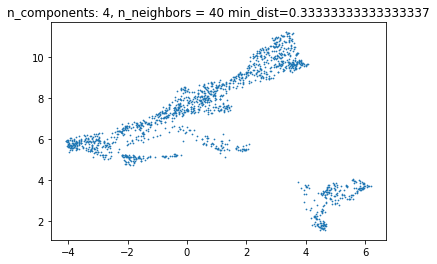

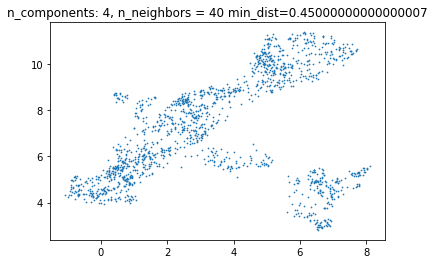

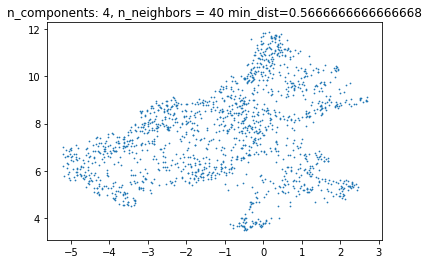

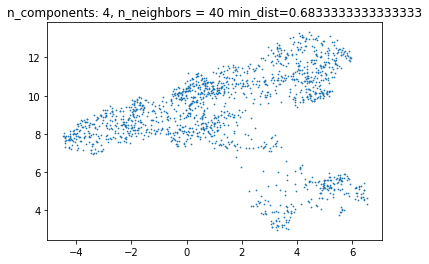

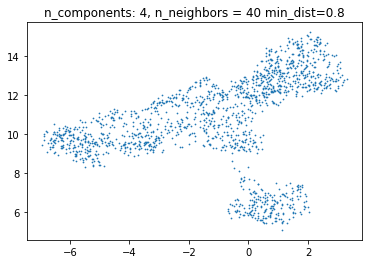

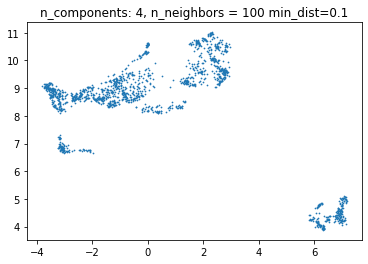

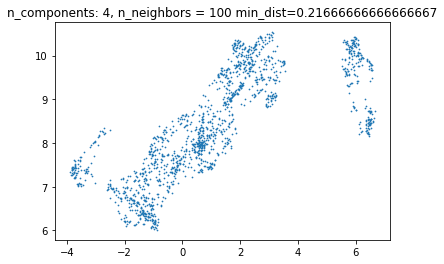

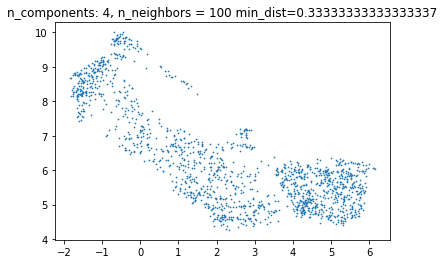

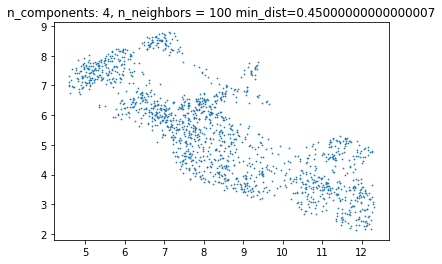

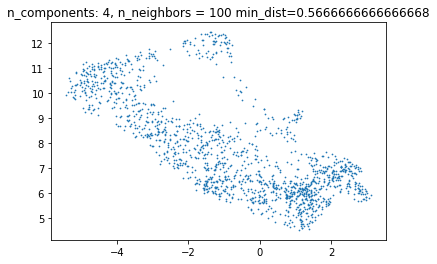

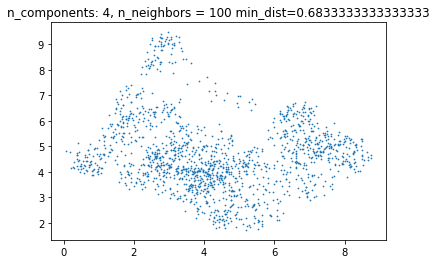

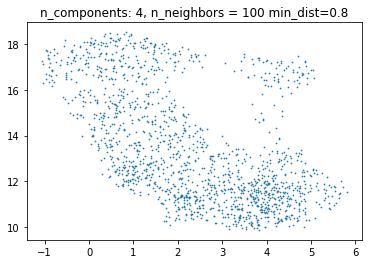

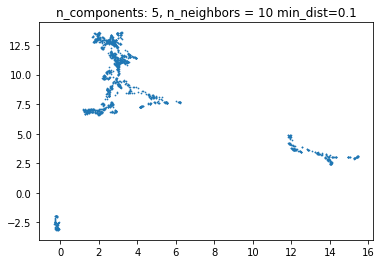

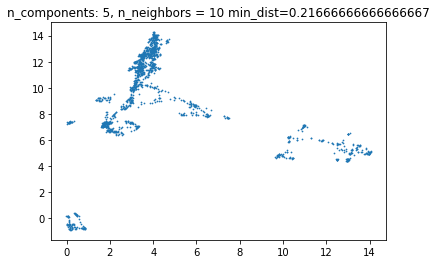

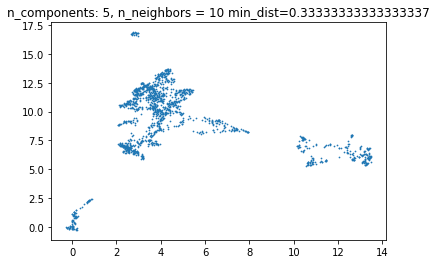

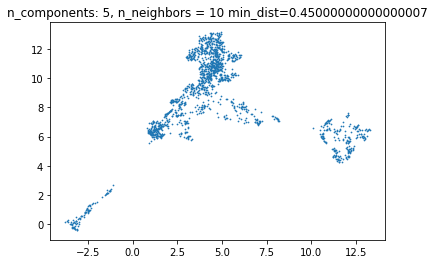

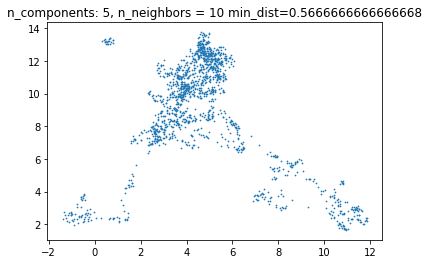

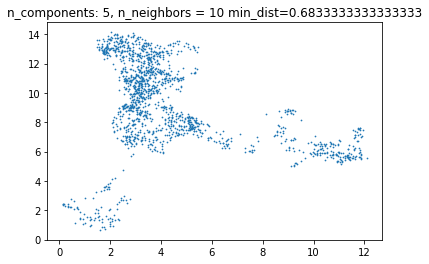

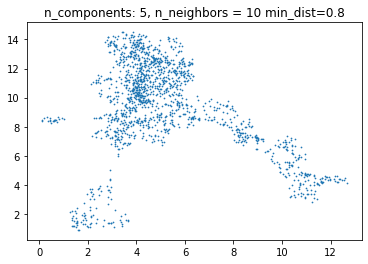

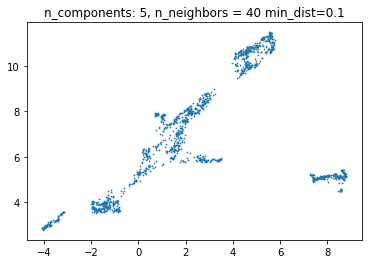

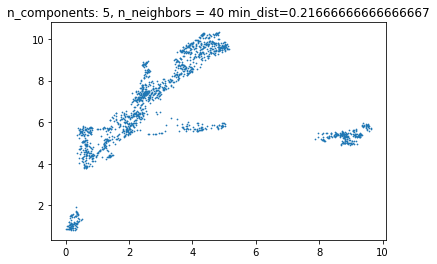

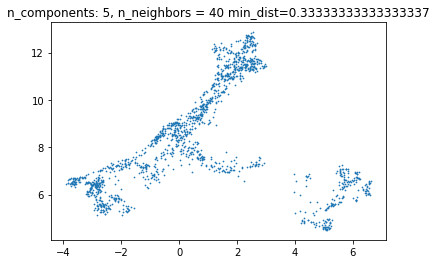

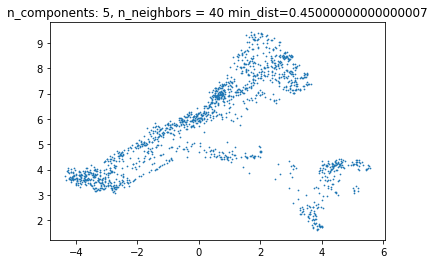

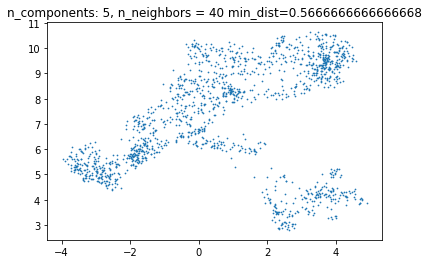

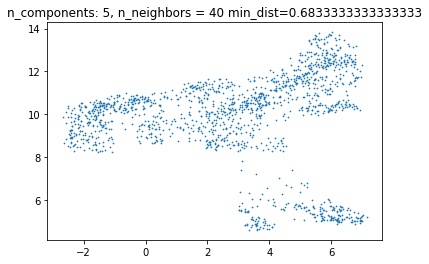

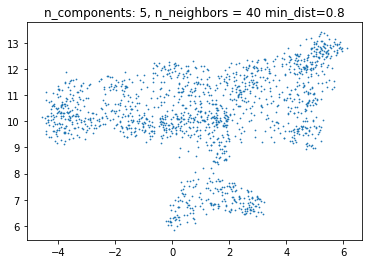

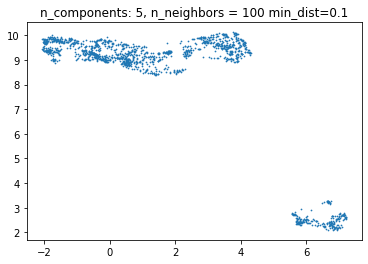

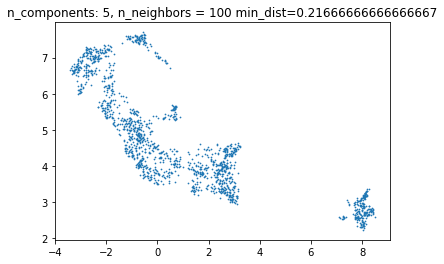

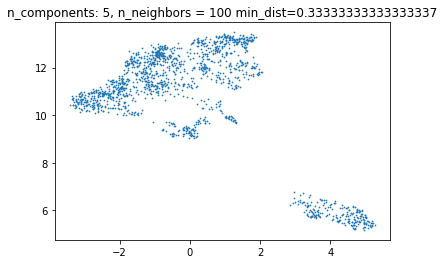

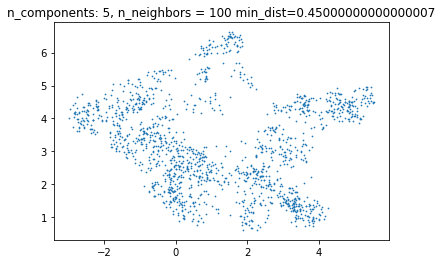

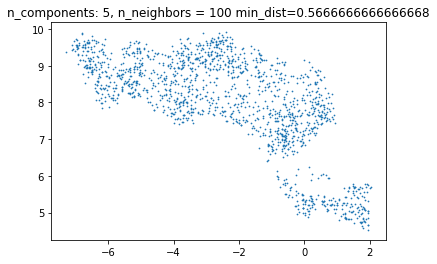

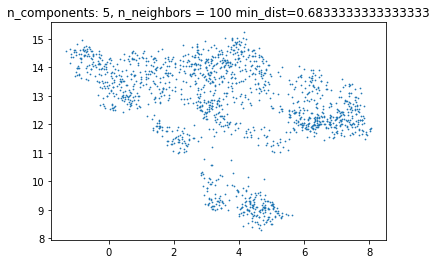

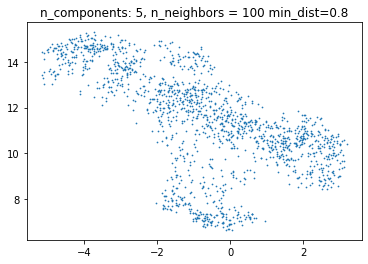

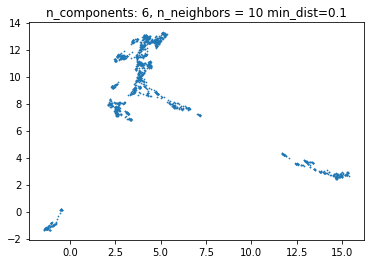

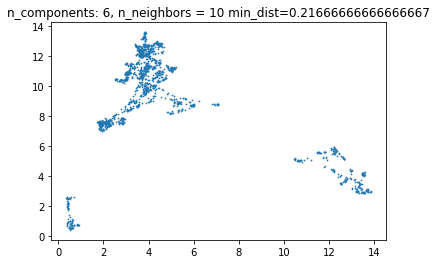

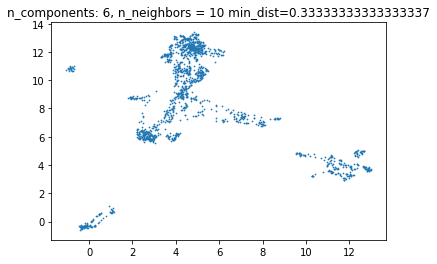

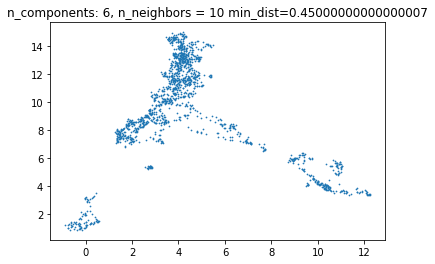

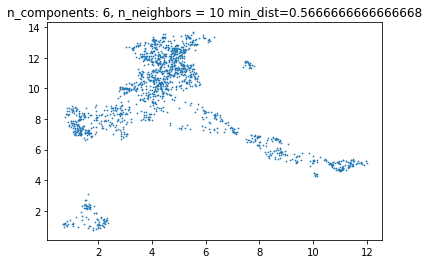

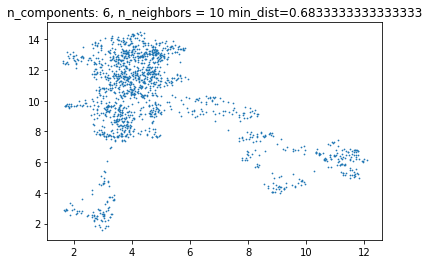

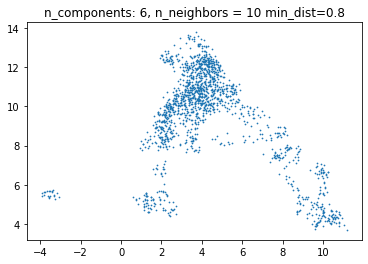

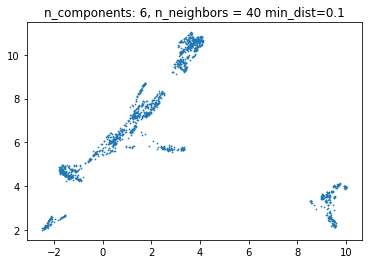

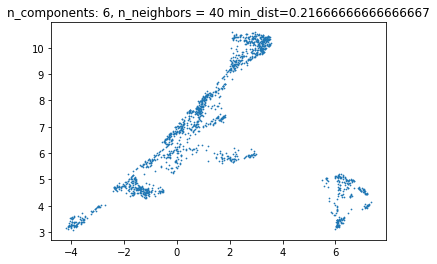

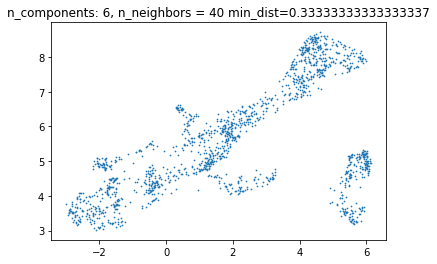

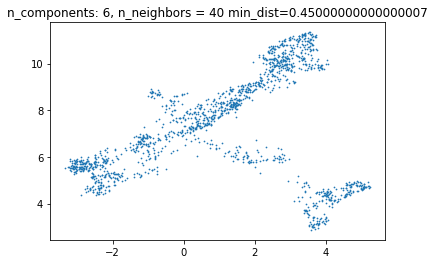

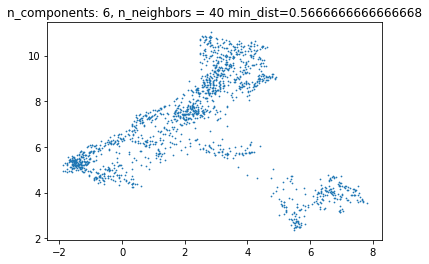

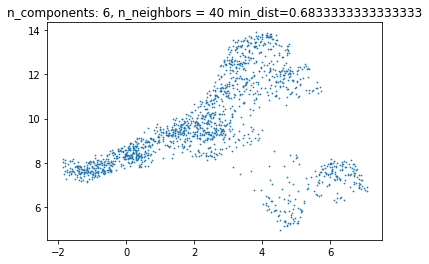

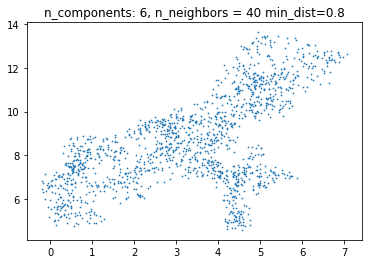

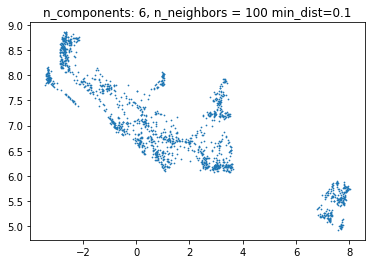

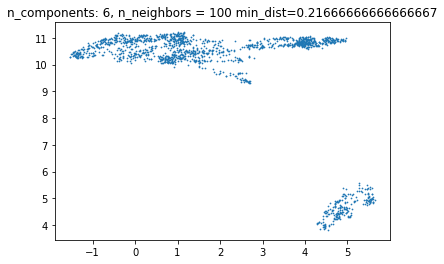

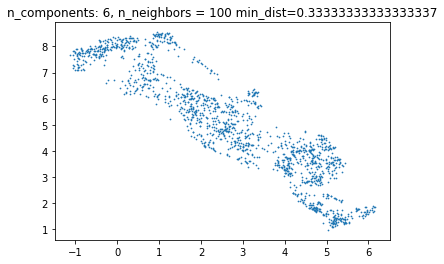

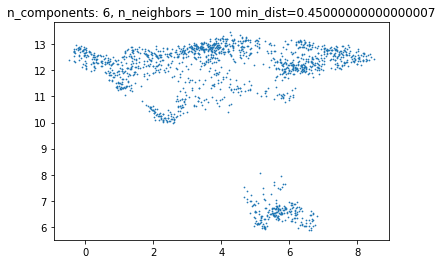

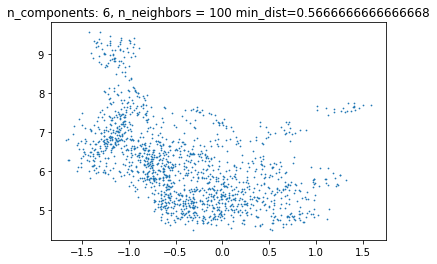

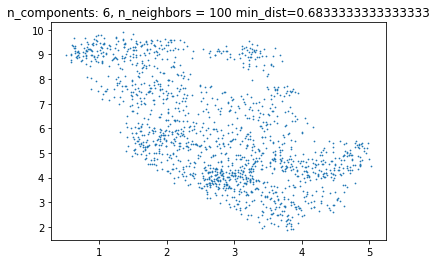

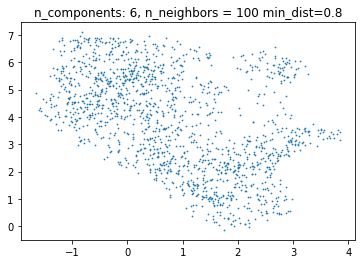

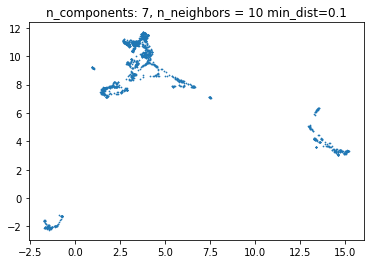

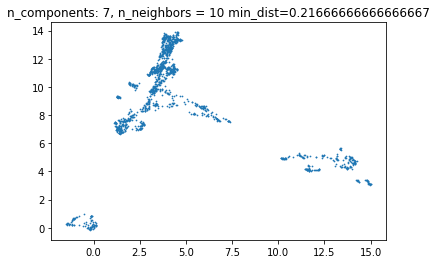

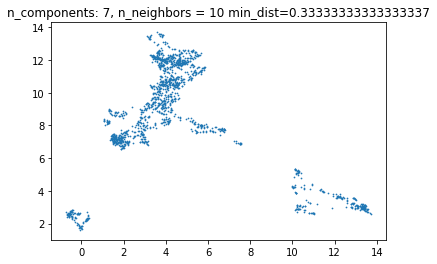

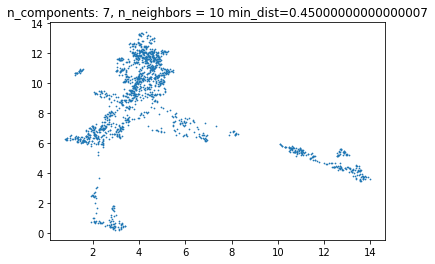

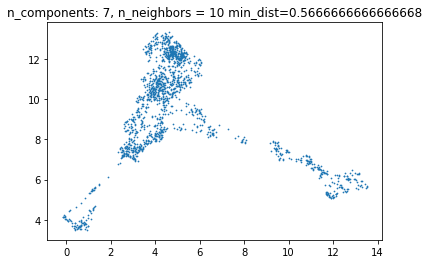

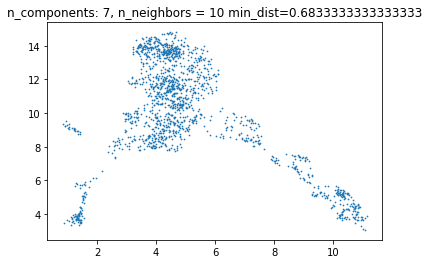

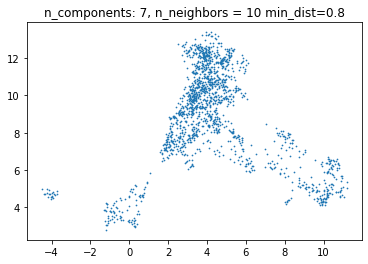

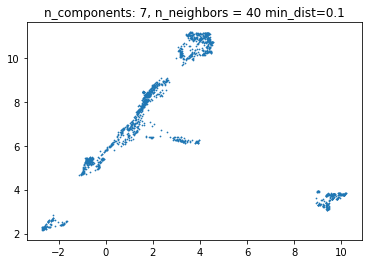

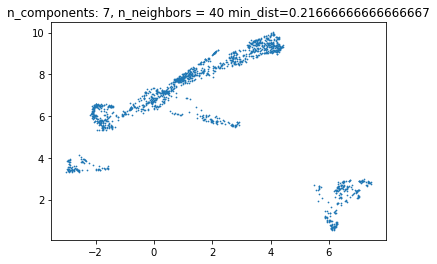

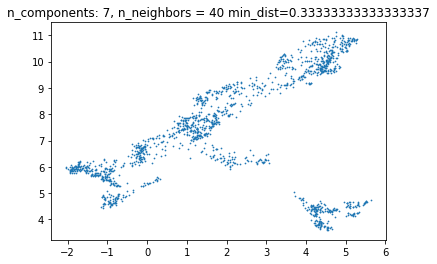

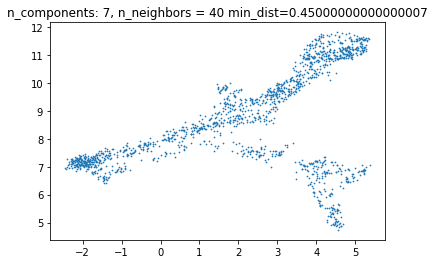

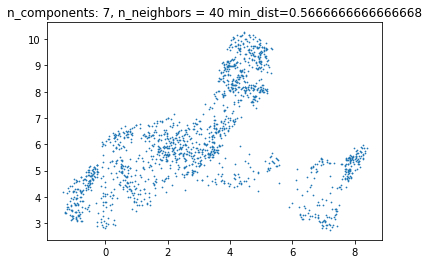

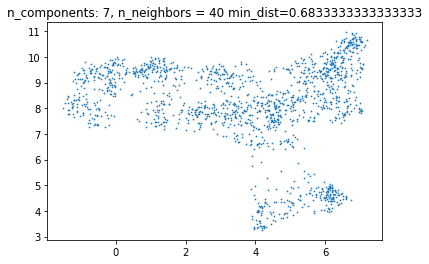

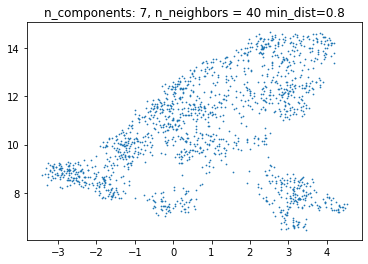

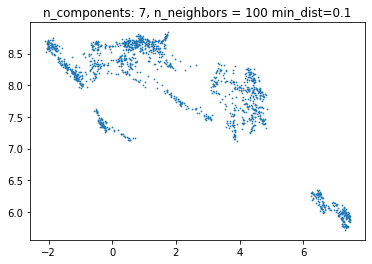

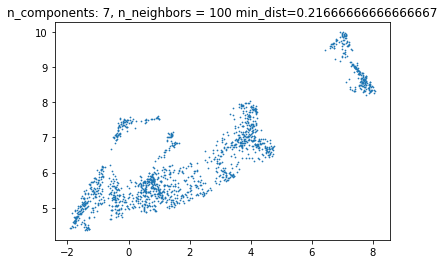

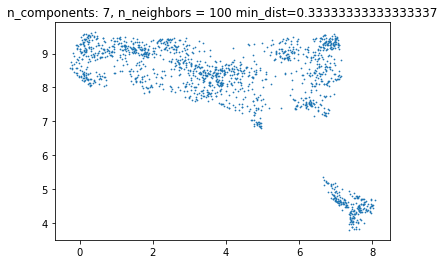

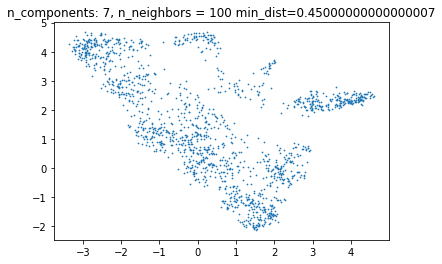

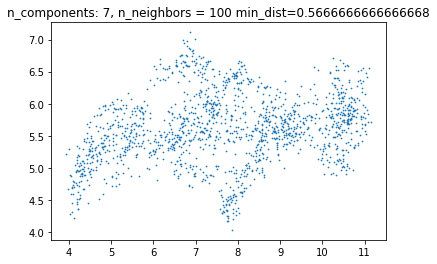

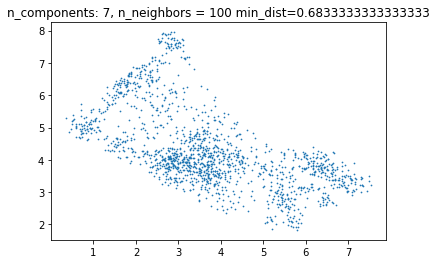

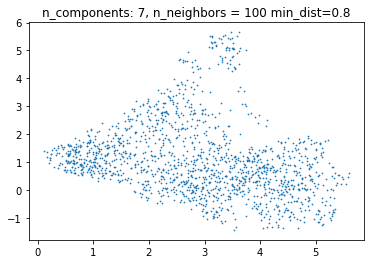

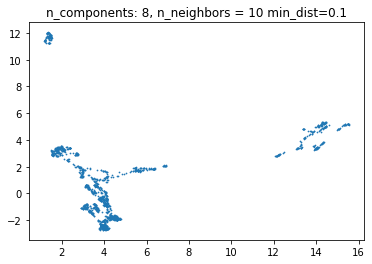

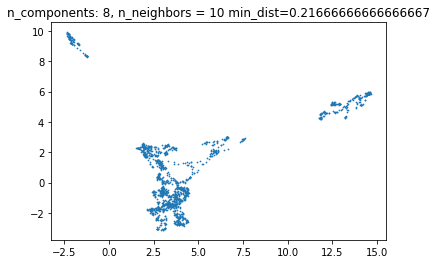

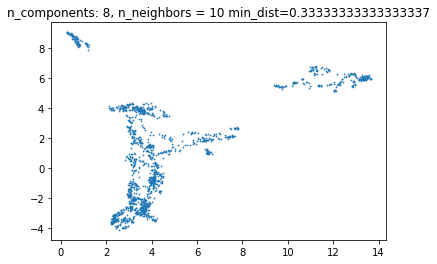

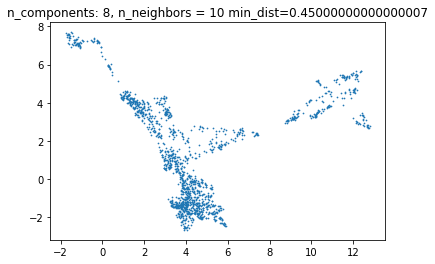

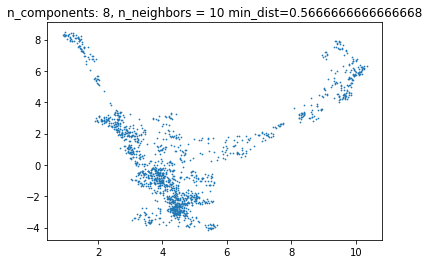

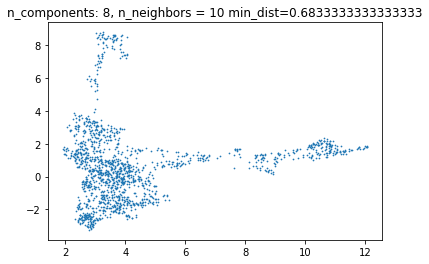

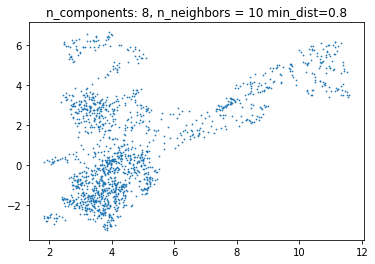

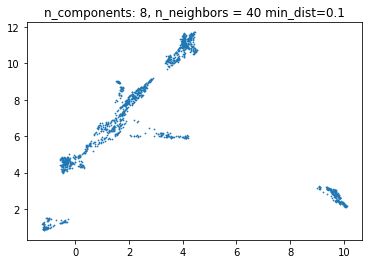

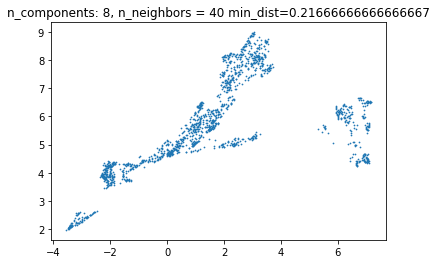

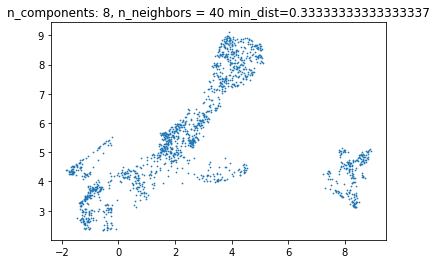

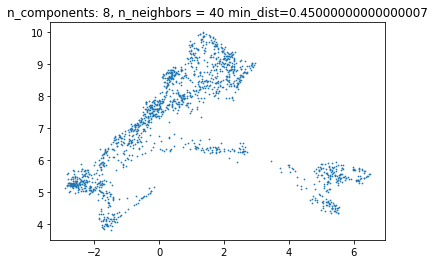

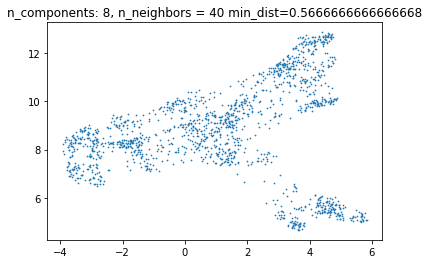

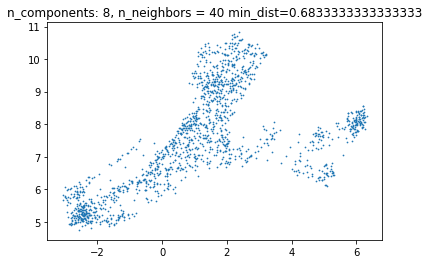

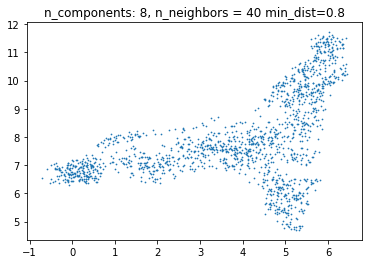

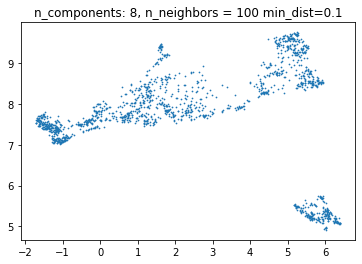

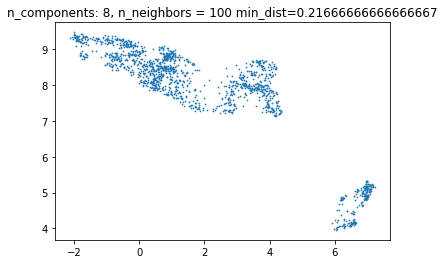

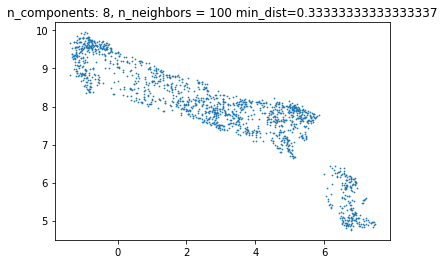

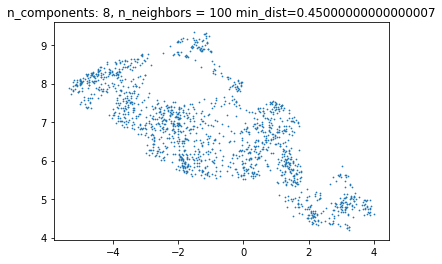

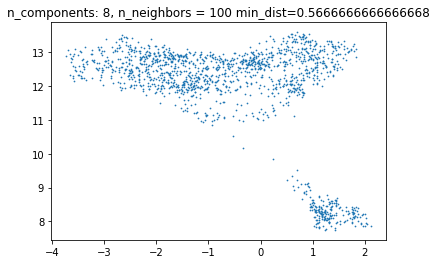

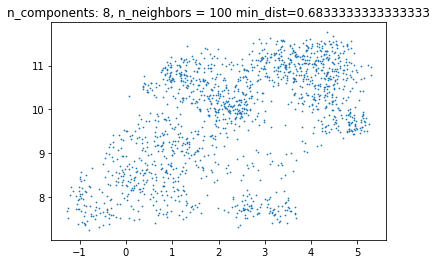

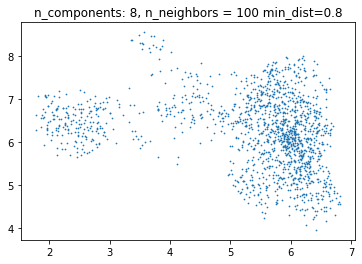

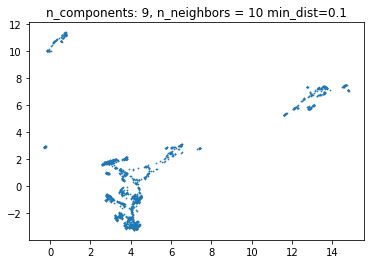

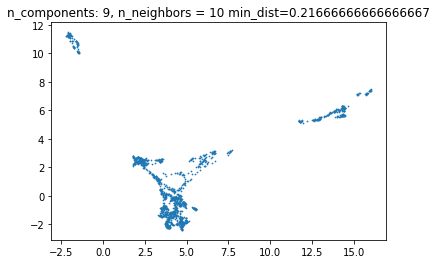

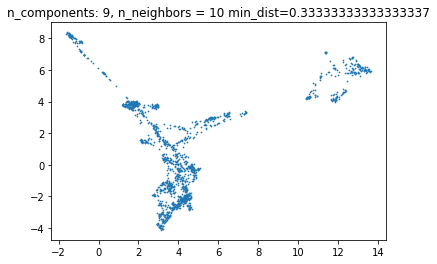

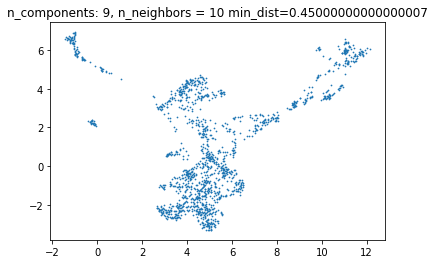

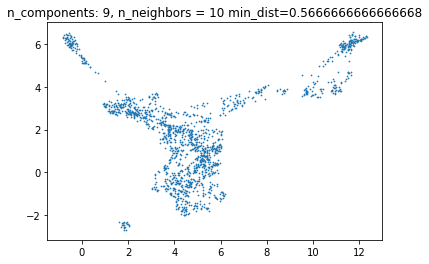

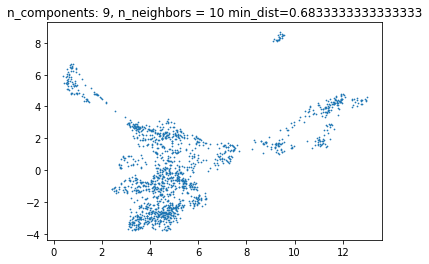

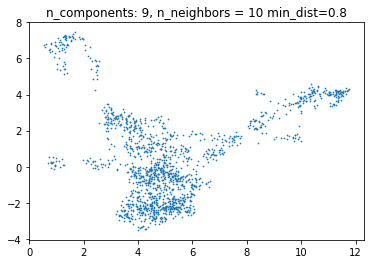

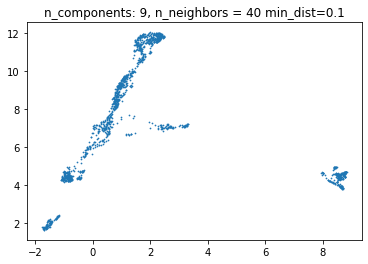

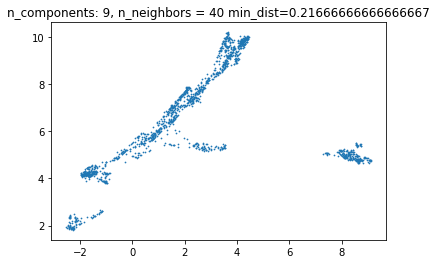

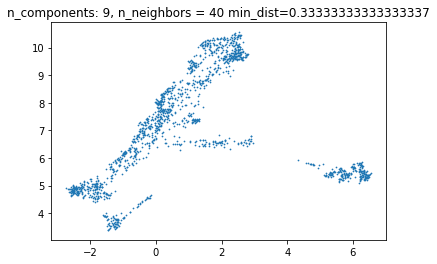

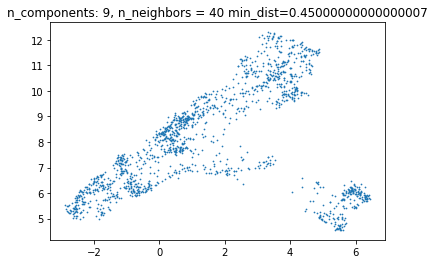

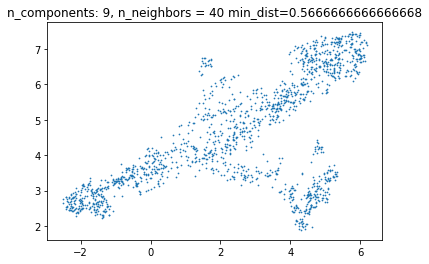

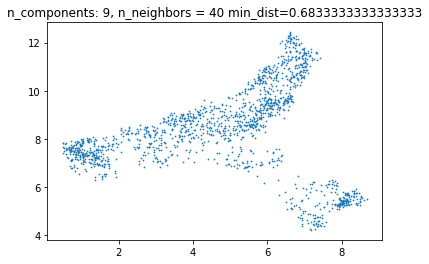

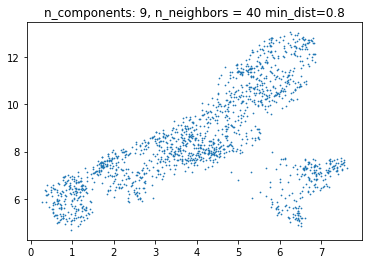

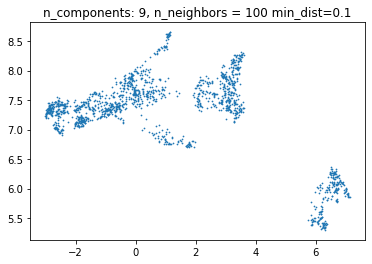

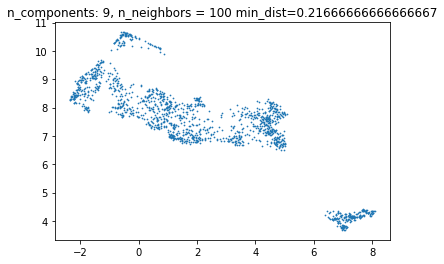

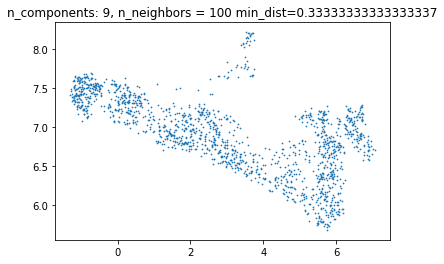

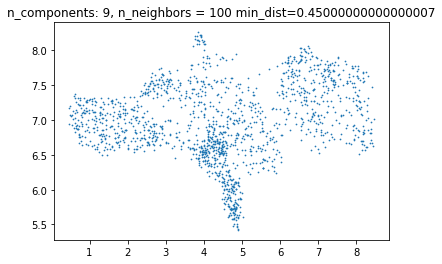

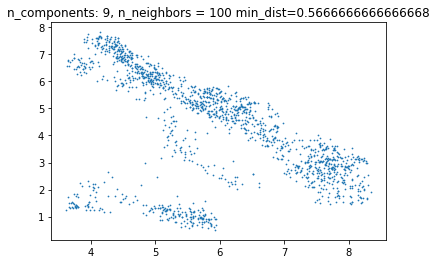

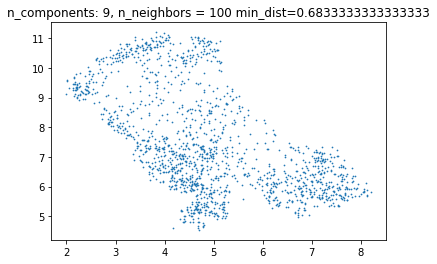

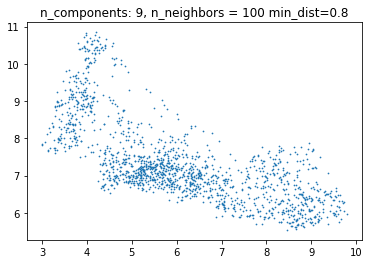

In [334]:
for n_comp in range(2,10):
    for n_nei in [10,40,100]:
        for min_dist in np.linspace(0.1,0.8,7):
            embedding_2d = UMAP(n_components=n_comp,
                                n_neighbors=n_nei,
                               min_dist=min_dist).fit_transform(shap_values[0])
            plt.figure()
            plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s = .5)
            plt.title(f"n_components: {n_comp}, n_neighbors = {n_nei} min_dist={min_dist}")

Text(0.5, 1.0, 'n_components: 8, n_neighbors = 40')

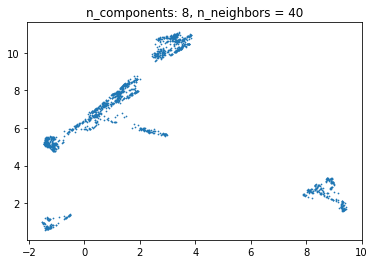

In [359]:
# Elijo una combinación que me haya gustado.
n_comp, n_nei, min_dist = 8, 40, 0.25

embedding_2d = UMAP(n_components=n_comp, n_neighbors=n_nei).fit_transform(shap_values[0])
plt.figure()
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s = 0.5)
plt.title(f"n_components: {n_comp}, n_neighbors = {n_nei}")

In [360]:
#! pip install hdbscan
import hdbscan

In [422]:
labels = hdbscan.HDBSCAN(
    min_samples=19,
    min_cluster_size=18,
).fit_predict(embedding_2d)

labels[clustered]

array([ 8,  0,  1, ..., 10,  2,  1])

In [423]:
labels[[i in [-1,4,5,7,8,9,10,11,12] for i in labels]] = 4

# Ojo, acá estoy dejando muestras sin clasificar.
clustered = (labels >= 0)


## Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

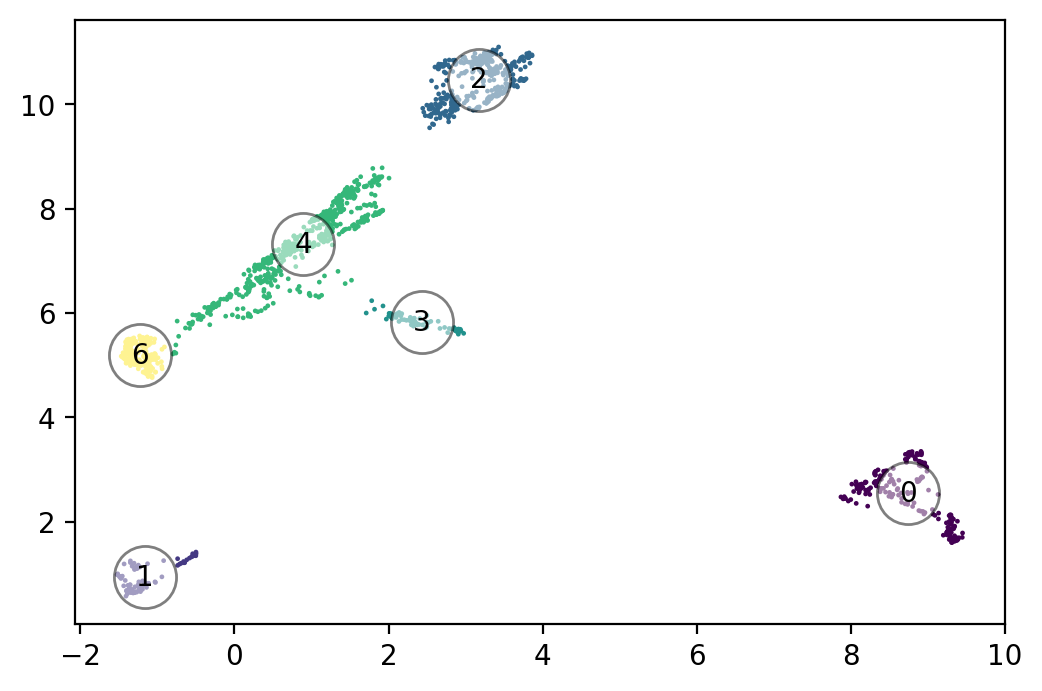

In [424]:
plt.figure(dpi = 200)
plt.scatter(embedding_2d[clustered, 0], embedding_2d[clustered, 1], c=labels[clustered], s=0.5, cmap='viridis');
# Si hay muestras sin clasificar, van en negro.
plt.scatter(embedding_2d[~clustered, 0], embedding_2d[~clustered, 1], c="black", s=.1)

shapx = embedding_2d[:, 0]
shapy = embedding_2d[:, 1]
label = labels
# Así vemos la media de cada grupo en los dos ejes.
shap_centroids = pd.DataFrame({"shapx":shapx,
             "shapy":shapy,
             "label":label }).groupby("label").mean()

for i,row in shap_centroids.iterrows():
    plt.scatter(row.shapx, row.shapy, s = 500, facecolors='white', edgecolors='k', alpha = .5)
    plt.text(row.shapx, row.shapy, s = str(i), va = "center", ha = "center", fontsize = 10)

In [425]:
Xbajas["cluster"] = labels

In [426]:
top_cols = list(lgbm_importancia.Features.head(10))

47.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
43.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


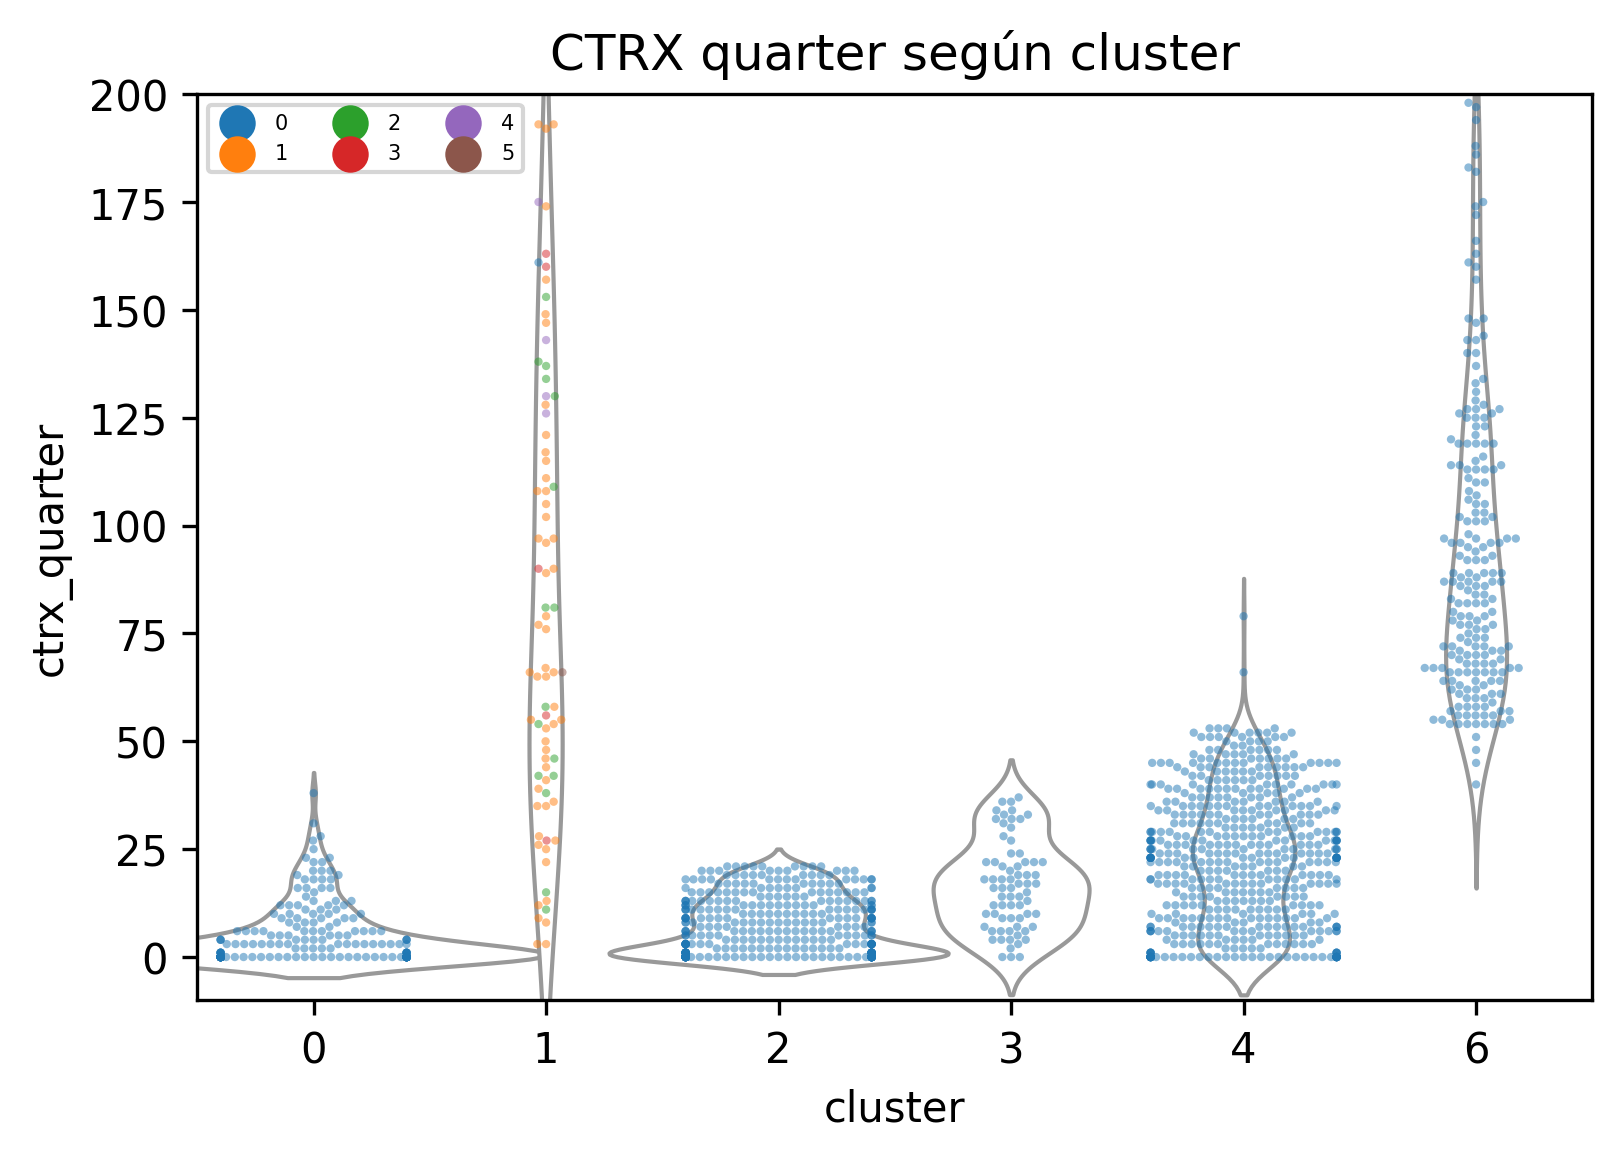

In [427]:
import seaborn as sns
plt.figure(dpi = 300)

sns.swarmplot(y="ctrx_quarter", 
                x="cluster", 
                data=Xbajas[Xbajas.ctrx_quarter < 200], 
                   hue="cpayroll_trx", palette = "tab10", s = 2, alpha = 0.5)

sns.violinplot(data = Xbajas[Xbajas.ctrx_quarter < 200],
            y = "ctrx_quarter", 
            x = "cluster", 
            saturation = 1,
            color = "white",
           linewidth = 1, width=2, inner= None)

plt.ylim(-10,200)
plt.title("CTRX quarter según cluster")
plt.legend(ncol = 3, fontsize = 5);

In [482]:
def coloured_table(columna):

    bajas = Xbajas[["cluster",columna]].groupby("cluster").describe()
    conts = Xtrain[ytrain == 0][[columna]].describe().transpose()
    bajas.index = [f"BAJA_{i}" for i in bajas.index]
    conts.index = ["CONTINUA"]

    bajas.columns = conts.columns
    print(columna)
    return bajas.append(conts)[["mean","25%","50%","75%"]].style\
    .background_gradient(cmap='hot', axis=None)\
    .highlight_null(null_color='#f1f1f1')\
    .set_precision(2)

In [483]:
coloured_table("mcuentas_saldo")

mcuentas_saldo


In [484]:
coloured_table("ctrx_quarter")

ctrx_quarter


In [ ]:
coloured_table("mcaja_ahorro")